In [ ]:
!pip install pyspark

# **LOAD DATASET**

In [ ]:
import pandas as pd
from pyspark.sql import SparkSession
from pyspark.sql.types import *
from pyspark.sql.functions import col,isnan, when, count
import matplotlib.pyplot as plt
import seaborn as sns
from pyspark.sql.functions import col
from pyspark.sql.types import DoubleType, IntegerType, FloatType
# Create a SparkSession
spark = SparkSession.builder.appName("WeatherDataPreprocessing").getOrCreate()

# Load the data into a Spark DataFrame
df = '/content/weather_classification_data.csv'
df = spark.read.csv(df, header=True, inferSchema=True)
print("Preview of the dataset:")
df.show(10, truncate=False)

Preview of the dataset:
+-----------+--------+----------+-----------------+-------------+--------------------+--------+------+---------------+--------+------------+
|Temperature|Humidity|Wind Speed|Precipitation (%)|Cloud Cover  |Atmospheric Pressure|UV Index|Season|Visibility (km)|Location|Weather Type|
+-----------+--------+----------+-----------------+-------------+--------------------+--------+------+---------------+--------+------------+
|14.0       |73      |9.5       |82.0             |partly cloudy|1010.82             |2       |Winter|3.5            |inland  |Rainy       |
|39.0       |96      |8.5       |71.0             |partly cloudy|1011.43             |7       |Spring|10.0           |inland  |Cloudy      |
|30.0       |64      |7.0       |16.0             |clear        |1018.72             |5       |Spring|5.5            |mountain|Sunny       |
|38.0       |83      |1.5       |82.0             |clear        |1026.25             |7       |Spring|1.0            |coastal |Sun

# **PRE-PROCESSING**

In [ ]:
# 1. Check data types
df.printSchema()

root
 |-- Temperature: double (nullable = true)
 |-- Humidity: integer (nullable = true)
 |-- Wind Speed: double (nullable = true)
 |-- Precipitation (%): double (nullable = true)
 |-- Cloud Cover: string (nullable = true)
 |-- Atmospheric Pressure: double (nullable = true)
 |-- UV Index: integer (nullable = true)
 |-- Season: string (nullable = true)
 |-- Visibility (km): double (nullable = true)
 |-- Location: string (nullable = true)
 |-- Weather Type: string (nullable = true)



In [ ]:
# 2. Rename columns
df = df.withColumnRenamed("Outlook", "Weather_Outlook")

In [ ]:
# 3. Check for null values
df.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in df.columns]).show()

+-----------+--------+----------+-----------------+-----------+--------------------+--------+------+---------------+--------+------------+
|Temperature|Humidity|Wind Speed|Precipitation (%)|Cloud Cover|Atmospheric Pressure|UV Index|Season|Visibility (km)|Location|Weather Type|
+-----------+--------+----------+-----------------+-----------+--------------------+--------+------+---------------+--------+------------+
|          0|       0|         0|                0|          0|                   0|       0|     0|              0|       0|           0|
+-----------+--------+----------+-----------------+-----------+--------------------+--------+------+---------------+--------+------------+



In [ ]:
from pyspark.ml.feature import StringIndexer
# Tentukan kolom kategorikal
categorical_cols = ["Cloud Cover", "Season", "Location", "Weather Type"]

# Buat objek StringIndexer
indexers = [StringIndexer(inputCol=col, outputCol=col + "_index") for col in categorical_cols]


In [ ]:
from pyspark.ml import Pipeline

# Buat pipeline
pipeline = Pipeline(stages=indexers)

# Sesuaikan dan transformasikan DataFrame
df = pipeline.fit(df).transform(df)

# Hapus kolom kategorikal asli
df = df.drop(*categorical_cols)

In [ ]:
df.show(5)

+-----------+--------+----------+-----------------+--------------------+--------+---------------+-----------------+------------+--------------+------------------+
|Temperature|Humidity|Wind Speed|Precipitation (%)|Atmospheric Pressure|UV Index|Visibility (km)|Cloud Cover_index|Season_index|Location_index|Weather Type_index|
+-----------+--------+----------+-----------------+--------------------+--------+---------------+-----------------+------------+--------------+------------------+
|       14.0|      73|       9.5|             82.0|             1010.82|       2|            3.5|              1.0|         0.0|           0.0|               1.0|
|       39.0|      96|       8.5|             71.0|             1011.43|       7|           10.0|              1.0|         1.0|           0.0|               0.0|
|       30.0|      64|       7.0|             16.0|             1018.72|       5|            5.5|              2.0|         1.0|           1.0|               3.0|
|       38.0|      83|

In [ ]:
# 5. Display summary statistics
df.describe().show()

+-------+-----------------+-----------------+-----------------+------------------+--------------------+-----------------+------------------+------------------+------------------+------------------+------------------+
|summary|      Temperature|         Humidity|       Wind Speed| Precipitation (%)|Atmospheric Pressure|         UV Index|   Visibility (km)| Cloud Cover_index|      Season_index|    Location_index|Weather Type_index|
+-------+-----------------+-----------------+-----------------+------------------+--------------------+-----------------+------------------+------------------+------------------+------------------+------------------+
|  count|            13200|            13200|            13200|             13200|               13200|            13200|             13200|             13200|             13200|             13200|             13200|
|   mean|19.12757575757576|68.71083333333333| 9.83219696969697|53.644393939393936|  1005.8278962121199|4.005757575757576| 5.46291666

In [ ]:
df.printSchema()

root
 |-- Temperature: double (nullable = true)
 |-- Humidity: integer (nullable = true)
 |-- Wind Speed: double (nullable = true)
 |-- Precipitation (%): double (nullable = true)
 |-- Atmospheric Pressure: double (nullable = true)
 |-- UV Index: integer (nullable = true)
 |-- Visibility (km): double (nullable = true)
 |-- Cloud Cover_index: double (nullable = false)
 |-- Season_index: double (nullable = false)
 |-- Location_index: double (nullable = false)
 |-- Weather Type_index: double (nullable = false)



In [ ]:
df.summary().show()

+-------+-----------------+-----------------+-----------------+------------------+--------------------+-----------------+------------------+------------------+------------------+------------------+------------------+
|summary|      Temperature|         Humidity|       Wind Speed| Precipitation (%)|Atmospheric Pressure|         UV Index|   Visibility (km)| Cloud Cover_index|      Season_index|    Location_index|Weather Type_index|
+-------+-----------------+-----------------+-----------------+------------------+--------------------+-----------------+------------------+------------------+------------------+------------------+------------------+
|  count|            13200|            13200|            13200|             13200|               13200|            13200|             13200|             13200|             13200|             13200|             13200|
|   mean|19.12757575757576|68.71083333333333| 9.83219696969697|53.644393939393936|  1005.8278962121199|4.005757575757576| 5.46291666

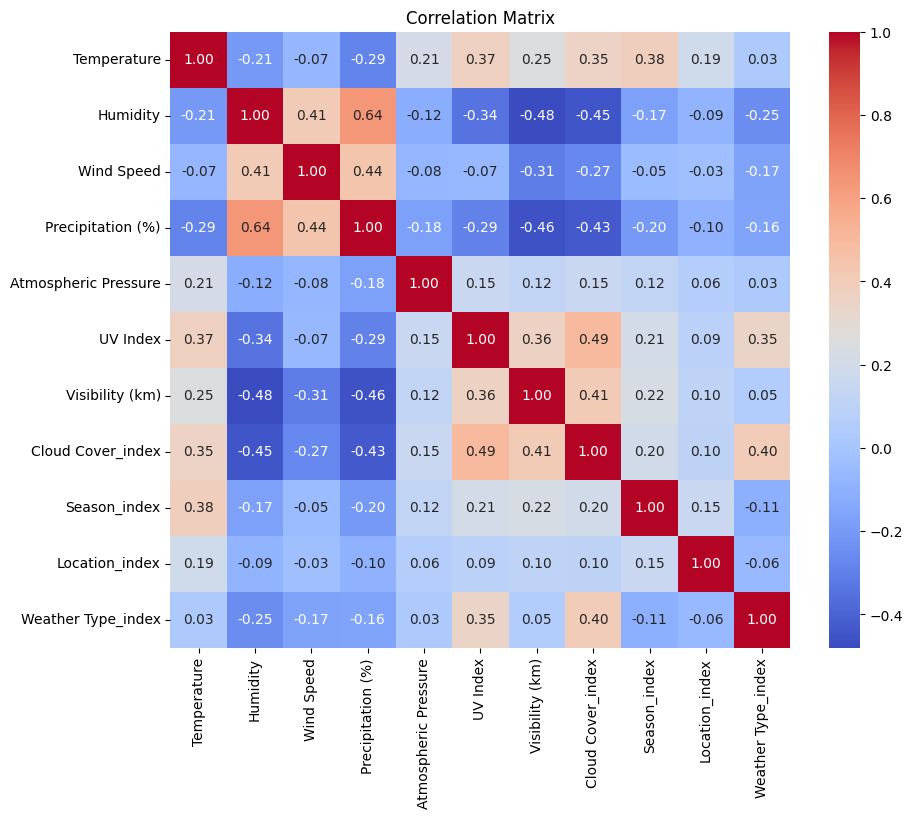

In [ ]:
pandas_df = df.toPandas()

import seaborn as sns

correlation_matrix = pandas_df.corr()

import matplotlib.pyplot as plt

plt.figure(figsize=(10, 8))  # Atur ukuran gambar
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix')
plt.show()

# **EDA**

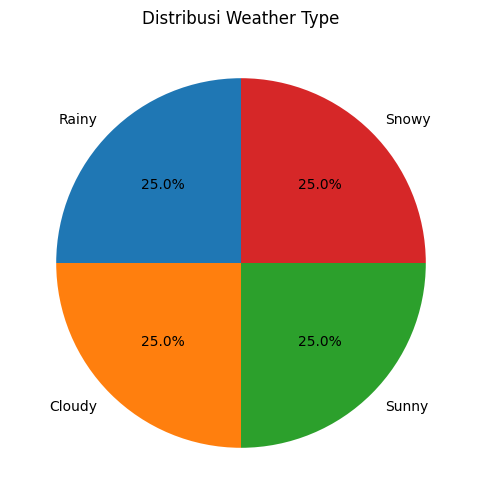

In [ ]:
# 0.0 = Cloudy
# 1.0 = Rainy
# 2.0 = Snowy
# 3.0 = Sunny

# Distribusi Weather Type
import matplotlib.pyplot as plt

# Hitung frekuensi setiap Weather Type
weather_type_counts = pandas_df['Weather Type_index'].value_counts()

# Mapping index ke label deskriptif
weather_labels = {0.0: 'Cloudy', 1.0: 'Rainy', 2.0: 'Snowy', 3.0: 'Sunny'}
weather_type_counts.index = [weather_labels[i] for i in weather_type_counts.index]

# Buat pie chart
plt.figure(figsize=(6, 6))
plt.pie(weather_type_counts, labels=weather_type_counts.index, autopct='%1.1f%%', startangle=90)
plt.title('Distribusi Weather Type')
plt.show()


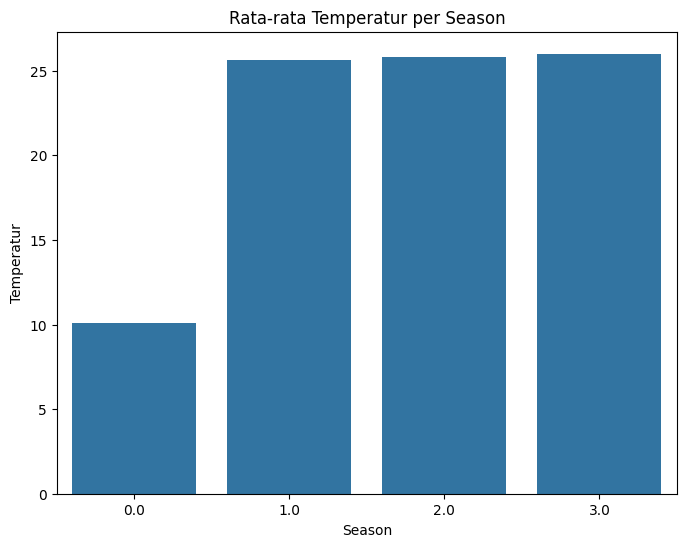

In [ ]:
# Rata-rata Temperatur per Season
import seaborn as sns

# Kelompokkan data berdasarkan Season dan hitung rata-rata Temperatur
season_temp = pandas_df.groupby('Season_index')['Temperature'].mean().reset_index()

# Buat bar chart
plt.figure(figsize=(8, 6))
sns.barplot(x='Season_index', y='Temperature', data=season_temp)
plt.title('Rata-rata Temperatur per Season')
plt.xlabel('Season')
plt.ylabel('Temperatur')
plt.show()

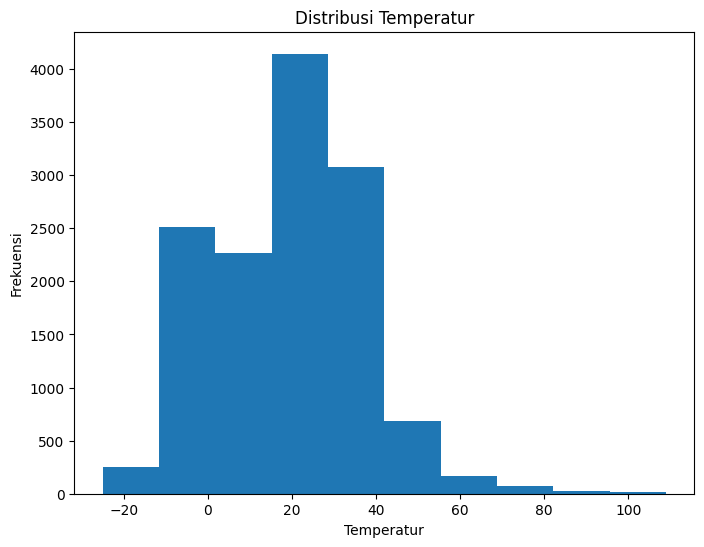

In [ ]:
# Distribusi Temperatur
import matplotlib.pyplot as plt

# Buat histogram
plt.figure(figsize=(8, 6))
plt.hist(pandas_df['Temperature'], bins=10)
plt.title('Distribusi Temperatur')
plt.xlabel('Temperatur')
plt.ylabel('Frekuensi')
plt.show()

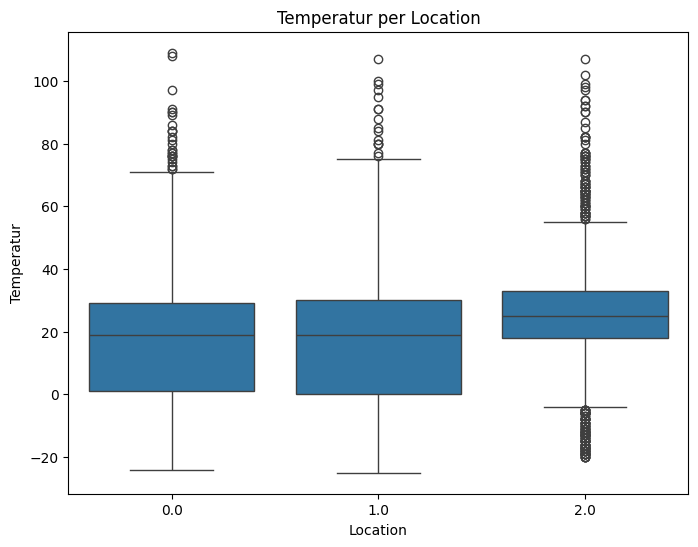

In [ ]:
# Temperatur per Location
import seaborn as sns

# Buat box plot
plt.figure(figsize=(8, 6))
sns.boxplot(x='Location_index', y='Temperature', data=pandas_df)
plt.title('Temperatur per Location')
plt.xlabel('Location')
plt.ylabel('Temperatur')
plt.show()

# **PEMODELAN**

In [ ]:
train_data, test_data = df.randomSplit([0.7, 0.3], seed=123)

In [ ]:
# Random forest
from pyspark.ml.feature import VectorAssembler

# Tentukan kolom fitur
feature_cols = ["Temperature", "Humidity", "Wind Speed", "Precipitation (%)",
                "Atmospheric Pressure", "UV Index", "Visibility (km)",
                "Cloud Cover_index", "Season_index", "Location_index"]

# Buat objek VectorAssembler
assembler = VectorAssembler(inputCols=feature_cols, outputCol="features")

# Transformasikan DataFrame untuk menambahkan kolom "features"
train_data = assembler.transform(train_data)
test_data = assembler.transform(test_data) # Applying to test data as well

# Sekarang Anda dapat melatih model RandomForest
from pyspark.ml.classification import RandomForestClassifier

rf = RandomForestClassifier(featuresCol="features", labelCol="Weather Type_index")
rf_model = rf.fit(train_data)

In [ ]:
# gradien boost tree
from pyspark.sql.functions import when

train_data = train_data.withColumn("Weather Type_index",
                                   when(train_data["Weather Type_index"] == 1, 1)
                                   .otherwise(0))
test_data = test_data.withColumn("Weather Type_index",
                                   when(test_data["Weather Type_index"] == 1, 1)
                                   .otherwise(0))
# proceed with the GBTClassifier
from pyspark.ml.classification import GBTClassifier

gbt = GBTClassifier(featuresCol="features", labelCol="Weather Type_index")
gbt_model = gbt.fit(train_data)

In [ ]:
# logistic regression
from pyspark.ml.classification import LogisticRegression

lr = LogisticRegression(featuresCol="features", labelCol="Weather Type_index")
lr_model = lr.fit(train_data)

In [ ]:
# decission tree
from pyspark.ml.classification import DecisionTreeClassifier

dt = DecisionTreeClassifier(featuresCol="features", labelCol="Weather Type_index")
dt_model = dt.fit(train_data)

In [ ]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

# Inisialisasi evaluator
evaluator = MulticlassClassificationEvaluator(labelCol="Weather Type_index", predictionCol="prediction", metricName="accuracy")

# Hitung dan tampilkan akurasi untuk setiap model
models = [rf_model, gbt_model, lr_model, dt_model]
model_names = ["Random Forest", "Gradient Boost Tree", "Logistic Regression", "Decision Tree"]

for model, name in zip(models, model_names):
    predictions = model.transform(test_data)
    accuracy = evaluator.evaluate(predictions)
    print(f"Akurasi {name}: {accuracy}")

Akurasi Random Forest: 0.4838227974116476
Akurasi Gradient Boost Tree: 0.9519661523145844
Akurasi Logistic Regression: 0.866351418616227
Akurasi Decision Tree: 0.9527127924340468


In [ ]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator, MulticlassClassificationEvaluator

In [ ]:
evaluator_binary = BinaryClassificationEvaluator(labelCol="Weather Type_index", rawPredictionCol="rawPrediction", metricName="areaUnderROC") # Untuk AUC

evaluator_multi = MulticlassClassificationEvaluator(labelCol="Weather Type_index", predictionCol="prediction")


In [ ]:
models = [rf_model, gbt_model, lr_model, dt_model]
model_names = ["Random Forest", "Gradient Boost Tree", "Logistic Regression", "Decision Tree"]

evaluator_multi = MulticlassClassificationEvaluator(labelCol="Weather Type_index", predictionCol="prediction")

for model, name in zip(models, model_names):
    predictions = model.transform(test_data)

    accuracy = evaluator_multi.evaluate(predictions, {evaluator_multi.metricName: "accuracy"})
    print(f"Accuracy {name}: {accuracy}")


    weightedPrecision = evaluator_multi.evaluate(predictions, {evaluator_multi.metricName: "weightedPrecision"})
    print(f"Weighted Precision {name}: {weightedPrecision}")

    weightedRecall = evaluator_multi.evaluate(predictions, {evaluator_multi.metricName: "weightedRecall"})
    print(f"Weighted Recall {name}: {weightedRecall}")

    weightedF1 = evaluator_multi.evaluate(predictions, {evaluator_multi.metricName: "weightedFMeasure"})
    print(f"Weighted F1 {name}: {weightedF1}")

Accuracy Random Forest: 0.4838227974116476
Weighted Precision Random Forest: 0.9236481783040658
Weighted Recall Random Forest: 0.4838227974116476
Weighted F1 Random Forest: 0.5944834213950803
Accuracy Gradient Boost Tree: 0.9519661523145844
Weighted Precision Gradient Boost Tree: 0.9520812527411637
Weighted Recall Gradient Boost Tree: 0.9519661523145844
Weighted F1 Gradient Boost Tree: 0.9520200313685315
Accuracy Logistic Regression: 0.866351418616227
Weighted Precision Logistic Regression: 0.8620518522295485
Weighted Recall Logistic Regression: 0.8663514186162269
Weighted F1 Logistic Regression: 0.8603800002154265
Accuracy Decision Tree: 0.9527127924340468
Weighted Precision Decision Tree: 0.9527127924340468
Weighted Recall Decision Tree: 0.9527127924340468
Weighted F1 Decision Tree: 0.9527127924340468


# **PERBANDINGAN HASIL MENGGUNAKAN METRIKS**

                 Model  Accuracy  Weighted Precision  Weighted Recall  \
0        Random Forest  0.483823            0.923648         0.483823   
1  Gradient Boost Tree  0.951966            0.952081         0.951966   
2  Logistic Regression  0.866351            0.862052         0.866351   
3        Decision Tree  0.952713            0.952713         0.952713   

   Weighted F1  
0     0.594483  
1     0.952020  
2     0.860380  
3     0.952713  


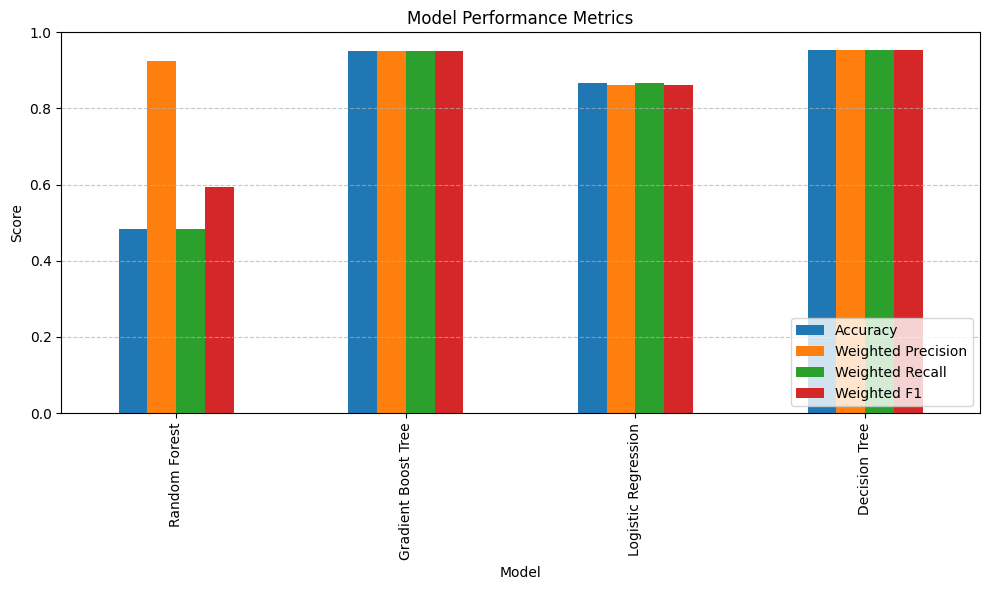

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Menyimpan hasil evaluasi dalam list
results = []

for model, name in zip(models, model_names):
    predictions = model.transform(test_data)

    accuracy = evaluator_multi.evaluate(predictions, {evaluator_multi.metricName: "accuracy"})
    weightedPrecision = evaluator_multi.evaluate(predictions, {evaluator_multi.metricName: "weightedPrecision"})
    weightedRecall = evaluator_multi.evaluate(predictions, {evaluator_multi.metricName: "weightedRecall"})
    weightedF1 = evaluator_multi.evaluate(predictions, {evaluator_multi.metricName: "weightedFMeasure"})

    results.append({
        "Model": name,
        "Accuracy": accuracy,
        "Weighted Precision": weightedPrecision,
        "Weighted Recall": weightedRecall,
        "Weighted F1": weightedF1
    })

# Membuat dataframe dari hasil evaluasi
df_results = pd.DataFrame(results)

# Menampilkan tabel hasil
print(df_results)

# Visualisasi menggunakan bar chart
df_results.set_index("Model").plot(kind="bar", figsize=(10, 6))
plt.title("Model Performance Metrics")
plt.ylabel("Score")
plt.xlabel("Model")
plt.ylim(0, 1)  # Karena metrik evaluasi berada pada rentang [0, 1]
plt.legend(loc="lower right")
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.tight_layout()
plt.show()

# **HYPERPARAMETER TUNNING**

In [ ]:
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

# Evaluator
evaluator = MulticlassClassificationEvaluator(labelCol="Weather Type_index", predictionCol="prediction", metricName="accuracy")

# 1. Gradient Boost Tree Hyperparameter Tuning
gbt = GBTClassifier(featuresCol="features", labelCol="Weather Type_index")

# Parameter Grid for GBT
gbt_param_grid = ParamGridBuilder() \
    .addGrid(gbt.maxDepth, [5, 10]) \
    .addGrid(gbt.maxBins, [32, 64]) \
    .addGrid(gbt.stepSize, [0.1, 0.2]) \
    .addGrid(gbt.maxIter, [10, 20]) \
    .build()

# CrossValidator for GBT
gbt_cv = CrossValidator(estimator=gbt, estimatorParamMaps=gbt_param_grid, evaluator=evaluator, numFolds=3)

# Fit Gradient Boost Tree
gbt_cv_model = gbt_cv.fit(train_data)
gbt_best_model = gbt_cv_model.bestModel

# Evaluate GBT on Test Data
gbt_predictions = gbt_best_model.transform(test_data)
gbt_accuracy = evaluator.evaluate(gbt_predictions)
print(f"GBT Best Accuracy: {gbt_accuracy}")

GBT Best Accuracy: 0.9544549527127925


In [ ]:
# 2. Decision Tree Hyperparameter Tuning
dt = DecisionTreeClassifier(featuresCol="features", labelCol="Weather Type_index")

# Parameter Grid for DT
dt_param_grid = ParamGridBuilder() \
    .addGrid(dt.maxDepth, [5, 10, 15]) \
    .addGrid(dt.maxBins, [32, 64]) \
    .build()

# CrossValidator for DT
dt_cv = CrossValidator(estimator=dt, estimatorParamMaps=dt_param_grid, evaluator=evaluator, numFolds=3)

# Fit Decision Tree
dt_cv_model = dt_cv.fit(train_data)
dt_best_model = dt_cv_model.bestModel

# Evaluate DT on Test Data
dt_predictions = dt_best_model.transform(test_data)
dt_accuracy = evaluator.evaluate(dt_predictions)
print(f"DT Best Accuracy: {dt_accuracy}")

# Comparison of Results
results = [
    {"Model": "Gradient Boost Tree", "Best Accuracy": gbt_accuracy},
    {"Model": "Decision Tree", "Best Accuracy": dt_accuracy}
]

# Display Results in Table
import pandas as pd
results_df = pd.DataFrame(results)
print(results_df)

DT Best Accuracy: 0.9544549527127925
                 Model  Best Accuracy
0  Gradient Boost Tree       0.954455
1        Decision Tree       0.954455


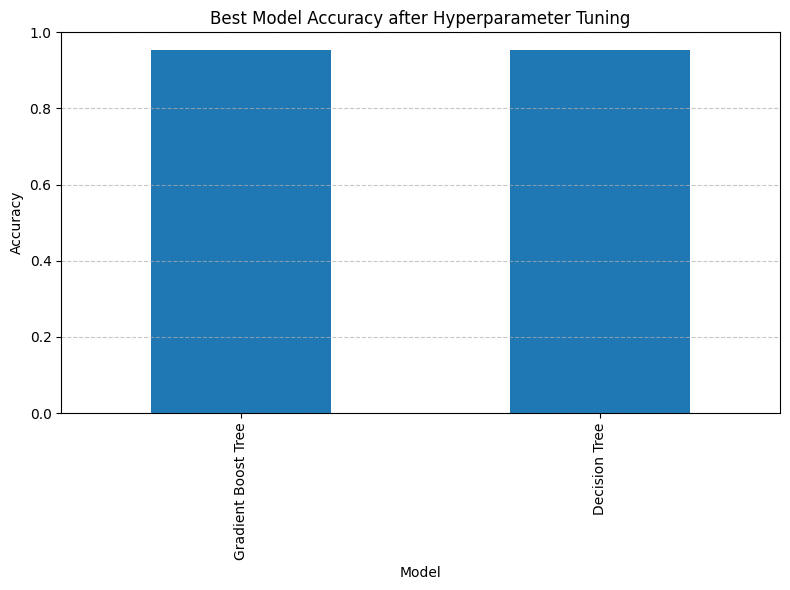

In [ ]:
# Visualize Comparison
import matplotlib.pyplot as plt
results_df.set_index("Model").plot(kind="bar", figsize=(8, 6), legend=False)
plt.title("Best Model Accuracy after Hyperparameter Tuning")
plt.ylabel("Accuracy")
plt.ylim(0, 1)
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.tight_layout()
plt.show()

In [ ]:
!jupyter nbconvert --to html /content/BDPA_Lanjut_FP_versi_baru_Klasifikasi_Jenis_Cuaca.ipynb

[NbConvertApp] Converting notebook /content/BDPA_Lanjut_FP_versi_baru_Klasifikasi_Jenis_Cuaca.ipynb to html
[NbConvertApp] WARNING | Alternative text is missing on 7 image(s).
[NbConvertApp] Writing 723489 bytes to /content/BDPA_Lanjut_FP_versi_baru_Klasifikasi_Jenis_Cuaca.html
